<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This work is based on the methodology originally developed by [Raissi](https://github.com/maziarraissi/PINNs/blob/master/main/continuous_time_identification%20(Navier-Stokes)/NavierStokes.py), and the Tensorflow 2.0 modification by [Blechschmidt](https://github.com/janblechschmidt/PDEsByNNs) and [pierremtb ](https://github.com/pierremtb/PINNs-TF2.0).

A Tensorflow 2.0 implementation of the inference problem for the Navier Stokes equation is [here](https://github.com/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_Solver.ipynb). This notebook is a Tensorflow 2.0 implementation of the Navier Stokes identification problem. We run this notebook with the original data provided by the author to test our implementation for the inference problem. This code is modified from [the heat identification code](https://github.com/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb)

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.io

from time import time

from IPython.display import clear_output

tf.experimental.numpy.experimental_enable_numpy_behavior()

clear_output()

## Get data for Navier Stokes

In [52]:
!git clone https://github.com/maziarraissi/PINNs

fatal: destination path 'PINNs' already exists and is not an empty directory.


In [53]:
import os
import sys

# "." for Colab/VSCode, and ".." for GitHub
repoPath = os.path.join(".", "PINNs")
# repoPath = os.path.join("..", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")

In [54]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

In [55]:
N_train = 5000

path = os.path.join(dataPath, "cylinder_nektar_wake.mat")
data = scipy.io.loadmat(path)

# define training and testing data
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

# print('X_star start and end; t_star start and end', X_star[0], X_star[-1], t_star[0], t_star[-1])

N = X_star.shape[0]
T = t_star.shape[0]

#Rearrange Data
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]

# Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

# make training and testing data
X = tf.concat([x_train,y_train,t_train], axis = 1)
data = tf.concat([u_train,v_train,p_train], axis = 1)

# print(x.min())
# print(x.max())
# print(y.min())
# print(y.max())
# print(t.min())
# print(t.max())
lb = tf.constant([x.min(), y.min(), t.min()],dtype = DTYPE)
ub = tf.constant([x.max(), y.max(), t.max()],dtype = DTYPE)

X_test = tf.concat([x_star,y_star,t_star], axis = 1)
data_test = tf.concat([u_star,v_star,p_star], axis = 1)

# print(X.size, data.size)

In [56]:
# ################### load data from google drive
# """
# To load data from Google Drive, download data from
# https://github.com/maziarraissi/PINNs/tree/master/main/Data
# and save it in a folder called "data" in your Google drive
# """
# from google.colab import drive
# drive.mount('/content/drive')
# data = scipy.io.loadmat('/content/drive/My Drive/data/cylinder_nektar_wake.mat')

In [57]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  input dimension = 3, for x, y, t
  output dimension = 1 for u, v, and p concatenated
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim

    self.lb = lb
    self.ub = ub

    # X = tf.concat([x,y,t], axis=1)
    # self.lb = X.min(0)
    # self.ub = X.max(0)
    # self.X = X
    # self.x = x
    # self.y = y
    # self.t = t
    # self.u = u
    # self.v = v

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - self.lb)/(self.ub - self.lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

### Two parameters to identify

In [58]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda

        self.lambd1 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd2_list = []

## Major modification in PINNSolver- Change dimensions of input and output variables

### to do
- use original data from Raissi

- change variable names

- run on HYAK

In [59]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.x = X_r[:,0:1]
        self.y = X_r[:,1:2]
        self.t = X_r[:,2:3]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

# differentiate to compute residual of PDE, physics information
    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            tape.watch(self.y)
            tape.watch(self.t)

            # compute current psi and p
            pp = self.model(tf.stack([self.x[:,0], self.y[:,0],self.t[:,0]], axis=1))
            psi = pp[:,0:1]
            p = pp[:,1:2]

            # Compute gradients
            u = tape.gradient(psi, self.y)
            v = -tape.gradient(psi, self.x)

            u_x = tape.gradient(u, self.x)
            u_y = tape.gradient(u, self.y)

            v_x = tape.gradient(v, self.x)
            v_y = tape.gradient(v, self.y)



        p_x = tape.gradient(p, self.x)
        p_y = tape.gradient(p, self.y)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)

        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        v_yy = tape.gradient(v_y, self.y)

        del tape

        return self.fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y)

# compute loss function- physics information + computational error
    def loss_fn(self, X, data):

        # Compute phi_r from model and X_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # compute loss at input data- concatenated u, v, p minus computed u, v, p
        data_pred = self.model(X)
        loss += tf.reduce_mean(tf.square(data - data_pred))

        return loss


# from the model, get model trainable variables and keep for gradient descent
    def get_grad(self, X, data):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, data)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

# compute residual from the neural net; physics information
    def fun_r(self, u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
        """Residual of the PDE"""
        f = u_t + self.model.lambd1 * (u * u_x + v * u_y) + p_x - self.model.lambd2 * (u_xx + u_yy)
        g = v_t + self.model.lambd1 * (u * v_x + v * v_y) + p_y - self.model.lambd2 * (v_xx + v_yy)
        return tf.concat([f, g], axis=1)

    def solve_with_TFoptimizer(self, optimizer, X, data, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, data)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2))

        self.hist.append(self.current_loss)
        self.iter += 1


    # def plot_solution(self, **kwargs):
    #     N = 411
    #     tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
    #     xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
    #     yspace = np.linspace(self.model.lb[2], self.model.ub[2], N)
    #     T, X, Y = np.meshgrid(tspace, xspace, yspace)
    #     Xgrid = np.vstack([T.flatten(),X.flatten(),Y.flatten()]).T
    #     upred = self.model(tf.cast(Xgrid,DTYPE))
    #     U = upred.numpy().reshape(N,N)
    #     fig = plt.figure(figsize=(9,6))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.plot_surface(T, X, Y, U, cmap='viridis', **kwargs)
    #     ax.set_xlabel('$t$')
    #     ax.set_ylabel('$x$')
    #     ax.set_zlabel('$u_\\theta(t,x)$')
    #     ax.view_init(35,35)
    #     return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

In [60]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,3))

# initialize PINN solver
solver = PINNSolver(model, X_test)

In [61]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X, data, N=6001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.67131616e-01 lambda1 = 1.00185812e+00 lambda2 = 9.90078211e-01
It 00100: loss = 2.33947528e-01 lambda1 = 1.16906464e+00 lambda2 = 6.46001399e-01
It 00200: loss = 2.27899517e-01 lambda1 = -6.80853352e-02 lambda2 = -7.26693077e-04
It 00300: loss = 2.26637701e-01 lambda1 = -4.87732477e-02 lambda2 = 1.76996074e-03
It 00400: loss = 2.25995766e-01 lambda1 = -3.28501649e-02 lambda2 = 1.08269171e-03
It 00500: loss = 2.25869907e-01 lambda1 = -2.20294520e-02 lambda2 = 1.89486949e-03
It 00600: loss = 2.25761958e-01 lambda1 = -1.73482671e-02 lambda2 = 6.69554051e-04
It 00700: loss = 2.25613874e-01 lambda1 = -1.38715794e-02 lambda2 = 2.85027374e-04
It 00800: loss = 2.25451176e-01 lambda1 = -1.28486957e-02 lambda2 = -7.70595871e-05
It 00900: loss = 2.25335415e-01 lambda1 = -1.15111303e-02 lambda2 = 5.68230462e-04
It 01000: loss = 2.25245177e-01 lambda1 = -1.15819676e-02 lambda2 = -1.29404303e-04
It 01100: loss = 2.25238210e-01 lambda1 = -1.18450010e-02 lambda2 = -3.44548083e-04
It

In [62]:
# solver.plot_solution();

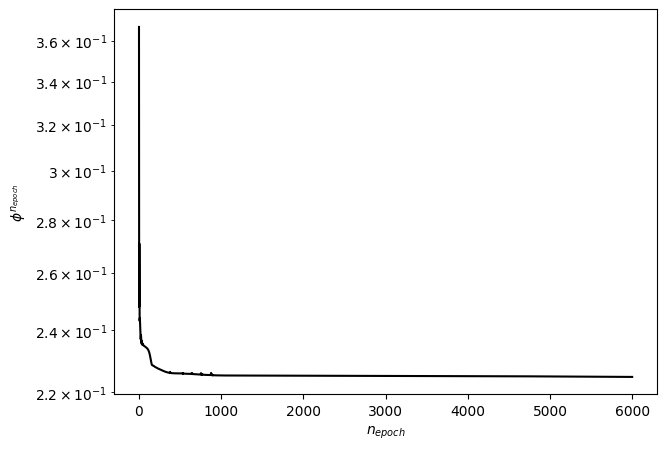

In [63]:
solver.plot_loss_history();

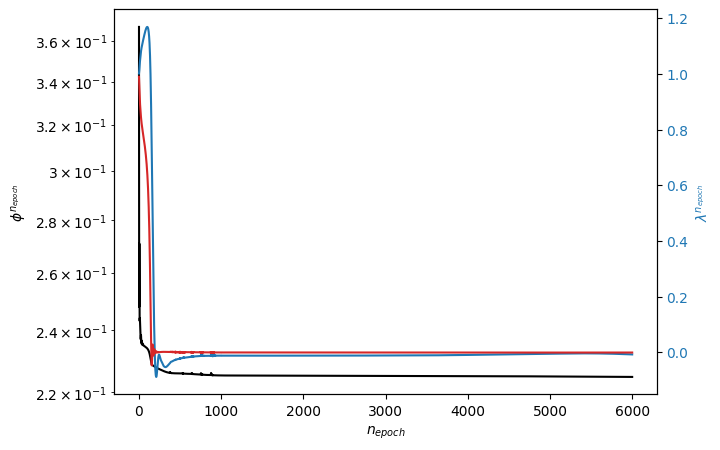

In [64]:
solver.plot_loss_and_param();